## Image stitching

Kornia is a differentiable library that allows classical computer vision to be integrated into deep learning models.

It consists of a set of routines and differentiable modules to solve generic computer vision problems. At its core, the package uses PyTorch as its main backend both for efficiency and to take advantage of the reverse-mode auto-differentiation to define and compute the gradient of complex functions.

In [1]:
import os
import kornia as K
import kornia.feature as KF
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from kornia.contrib import ImageStitcher

We get the path of the current directory and specify the path to the folder with images. You can take any images, but you need them to contain key points

In [2]:
current_dir=os.getcwd()
# specify the image directories
pkg_path='\\files'
pkg_path = os.path.join(os.path.realpath(current_dir+pkg_path))
# adding all files to the list
file_list=[i for i in os.listdir(pkg_path)]

In [3]:
# load images function (from image to tensor)
def load_image(pack_image,fname,new_size:tuple):
    img=cv2.imread(pack_image+'\\'+fname).astype(np.float32)
    resize_img=cv2.resize(img,new_size)
    return resize_img

def preprocess_image(img):
    # print(f"Input image type: {type(img)}")
    # print(f"Input image shape: {img.shape if hasattr(img, 'shape') else 'No shape attribute'}")
    
    # Convert numpy array to Tensor and ensure correct shape
    if isinstance(img, np.ndarray):
        img = K.image_to_tensor(img, keepdim=False).float() / 255.0
    elif isinstance(img, torch.Tensor):
        img = img.float()
        if img.max() > 1.0:
            img = img / 255.0
    else:
        raise ValueError(f"Unsupported image type: {type(img)}")
    
    # print(f"After conversion to tensor - shape: {img.shape}")
    
    # Ensure 4D tensor (B, C, H, W)
    if img.ndim == 2:
        img = img.unsqueeze(0).unsqueeze(0)
    elif img.ndim == 3:
        if img.shape[0] in [1, 3]:
            img = img.unsqueeze(0)
        else:
            img = img.unsqueeze(1)
    elif img.ndim == 4:
        if img.shape[1] not in [1, 3]:
            img = img.permute(0, 3, 1, 2)
    
    # print(f"After ensuring 4D - shape: {img.shape}")
    
    # Ensure 3 channel image
    if img.shape[1] == 1:
        img = img.repeat(1, 3, 1, 1)
    elif img.shape[1] > 3:
        img = img[:, :3]  # Take only the first 3 channels if more than 3
    
    # print(f"Final tensor shape: {img.shape}")
    return img

# make list of img tensors
def tensor_pkg(pkg_path,file_list,new_size:tuple):
    return [preprocess_image(load_image(pkg_path,file_list[i],new_size)) for i in range(len(file_list))]


C:\Users\Kirilll\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\kornia\geometry\homography.py:239: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ..\aten\src\ATen\native\Cross.cpp:66.)
  torch.cross(src_perm[..., 1:2, :], src_perm[..., 2:3, :]) @ src_perm[..., 0:1, :].permute(0, 1, 3, 2)


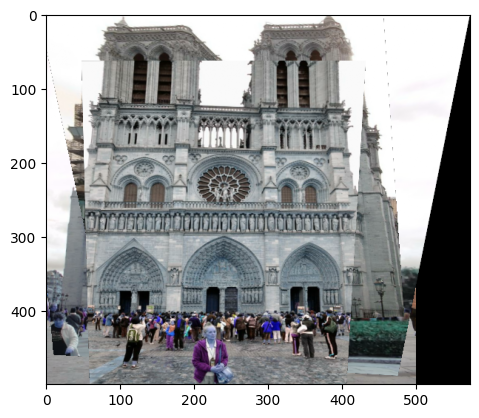

In [4]:
# creating a list containing the original images in the form of a tensor
tensor_pack=tensor_pkg(pkg_path,file_list,(500,500))

IS = ImageStitcher(KF.LoFTR(pretrained="outdoor"), estimator="ransac")

with torch.no_grad():
    out = IS(*tensor_pack)

plt.imshow(K.tensor_to_image(out))
plt.show()